# Notebook Instructions
<i>You can run the notebook document sequentially (one cell at a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i> <BR>
    
This course is based on specific versions of python packages. You can find the details of the same in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>. The manual also explains how to use these codes in other versions of python packages. <BR>

# Hurst exponent strategy

In this notebook, we will create a strategy using the Hurst exponent and the RSI. 
The strategy works as follows:
1. Fetch the minute data for Ethereum/USDT from a csv file
3. Convert the unix epoch time to normal datetime format and set it as index
4. Compute the hurst value for the entire price series
5. Compute the rolling hurst values for with a lookback period of 240 minutes
6. Compute the signals to indicate the persistent nature of the market
7. Calculate the RSI values
8. Calcualte the market returns
9. Calcualte the strategy returns
10. Compute the cumulative strategy return and plot it
11. Compute the slippage 
12. Calculate the net profit after slippage

## Import data and libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import talib as ta
from hurst import compute_Hc

ModuleNotFoundError: No module named 'hurst'

In [4]:
# If you do not have the hurst library please install it by running the below code
!pip install hurst

  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ConnectTimeoutError(<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7fa1cb878a50>, 'Connection to pypi.org timed out. (connect timeout=15)')': /simple/hurst/


  Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ConnectTimeoutError(<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7fa1cb878c10>, 'Connection to pypi.org timed out. (connect timeout=15)')': /simple/hurst/


  Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ConnectTimeoutError(<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7fa1cb878050>, 'Connection to pypi.org timed out. (connect timeout=15)')': /simple/hurst/


  Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ConnectTimeoutError(<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7fa1cb878610>, 'Connection to pypi.org timed out. (connect timeout=15)')': /simple/hurst/


  Retrying (Retry(total=0, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ConnectTimeoutError(<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x7fa1cb878590>, 'Connection to pypi.org timed out. (connect timeout=15)')': /simple/hurst/


  Could not find a version that satisfies the requirement hurst (from versions: )
No matching distribution found for hurst


In [3]:
df1=pd.read_csv("1min_ETHUSDT-Upload.csv").iloc[-100000:]
# Set the timestamp to be the index for the data
df1=df1.set_index('Timestamp')

### Convert the unix time stamp to datetime

In [4]:
df1.index=pd.to_datetime(df1.index, unit='ms')

### Compute the hurst value for the data

In [5]:
series=df1.Close
H = compute_Hc(series, kind='price')[0]

In [6]:
print("Hurst Exponent H={:.4f}".format(H))

Hurst Exponent H=0.6204


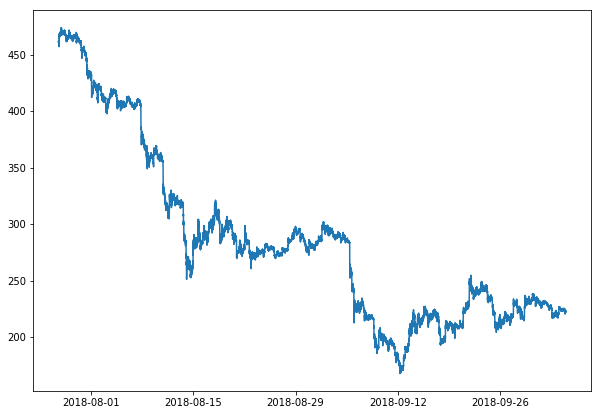

In [7]:
# Let us visualize the data to confirm if it really was trending for the given time frame
plt.figure(figsize=(10,7))
plt.plot(df1.Close)

### Compute the rolling hurst values

In [8]:
df1['H']=0

#### We are using the past 4 hour data to calculate the hurst exponent.

In [9]:
for i in range(240,len(df1)):
    df1.H.iloc[i]=compute_Hc(df1.Close.iloc[i-240:i-1], kind='price')[0]

C:\Users\udish\Anaconda3\envs\py35\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


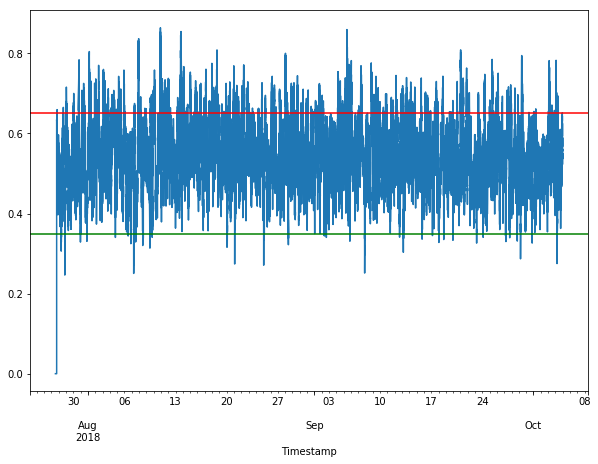

In [10]:
# Let us plot the hurst values to visualize it
# We will be using threshold values of 0.65 and 0.35 to avoid trading for the noise
plt.figure(figsize=(10,7))
df1.H.plot()
plt.axhline(0.35,color='g')
plt.axhline(0.65,color='r')

### Generate the persitence signals

In [11]:
df1['Signal']= 0
df1['Signal']=np.where( df1.H>0.65,1,df1.Signal)
df1['Signal']=np.where( df1.H<0.35,-1,df1.Signal)

### Compute the RSI 

In [12]:
df1['RSI'] = ta.RSI(df1.Close.shift(1).values,14)

### Compute the market return

In [13]:
# Since we use the previous Close price to calculate the RSI and Hurst values, we use the close prices to calculate
# the market returns during the execution of the strategy.
df1['Return']=df1.Close.pct_change()

### Compute the strategy returns

We use RSI here to gauge the overbought/oversold condition of the market.

We <font color=blue>buy</font>  when

1. RSI is more than 75 and Persistence signal is 1
2. RSI is less than 25 and Persistence signal is -1

We <font color=red>sell</font>  when

1. RSI is more than 75 and Persistence signal is -1
2. RSI is less than 25 and Persistence signal is 1

In [14]:
df1['StrReturn']=0
df1['StrReturn']= np.where(((df1.RSI>75) & (df1.Signal==-1)),-df1.Return,df1.StrReturn)
df1['StrReturn']= np.where(((df1.RSI<25) & (df1.Signal==-1)),df1.Return,df1.StrReturn)
df1['StrReturn']= np.where(((df1.RSI>75) & (df1.Signal==1)),df1.Return,df1.StrReturn)
df1['StrReturn']= np.where(((df1.RSI<25) & (df1.Signal==1)),-df1.Return,df1.StrReturn)

### Compute the total slipapge cost

In [15]:
# When we execute a strategy based on market orders our strategy can experience a significant slippage,
# if the bid-ask prices are far away. So, we have taken an average bid-ask spread of 0.05 based on the orderbook 
# data from cryptoexchanges.

total_slippage_cost=len(df1[df1.StrReturn!=0])*0.05/df1.Close.mean()
total_slippage_cost

0.12242743305187771

In [16]:
Cumulative_Returns=df1.StrReturn.expanding().sum()

### Plot the cumulative returns of the strategy

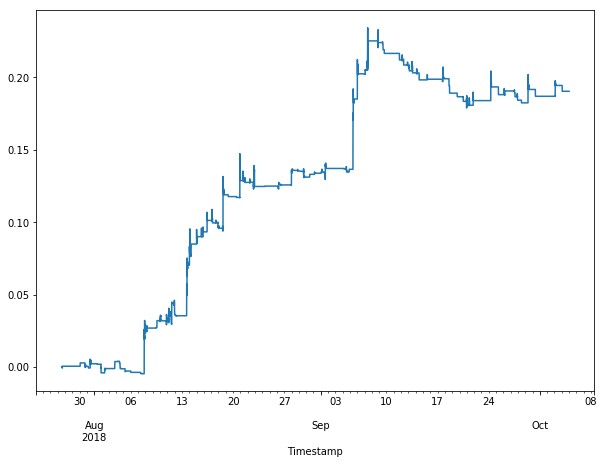

In [17]:
plt.figure(figsize=(10,7))
Cumulative_Returns.plot()

### Compute the net profit after slippage

In [18]:
Final_percentage_retuns=(Cumulative_Returns.iloc[-1]-total_slippage_cost)*100

In [19]:
Final_percentage_retuns

6.805456409238202